# 1) Installation and Library Imports

##Set up Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


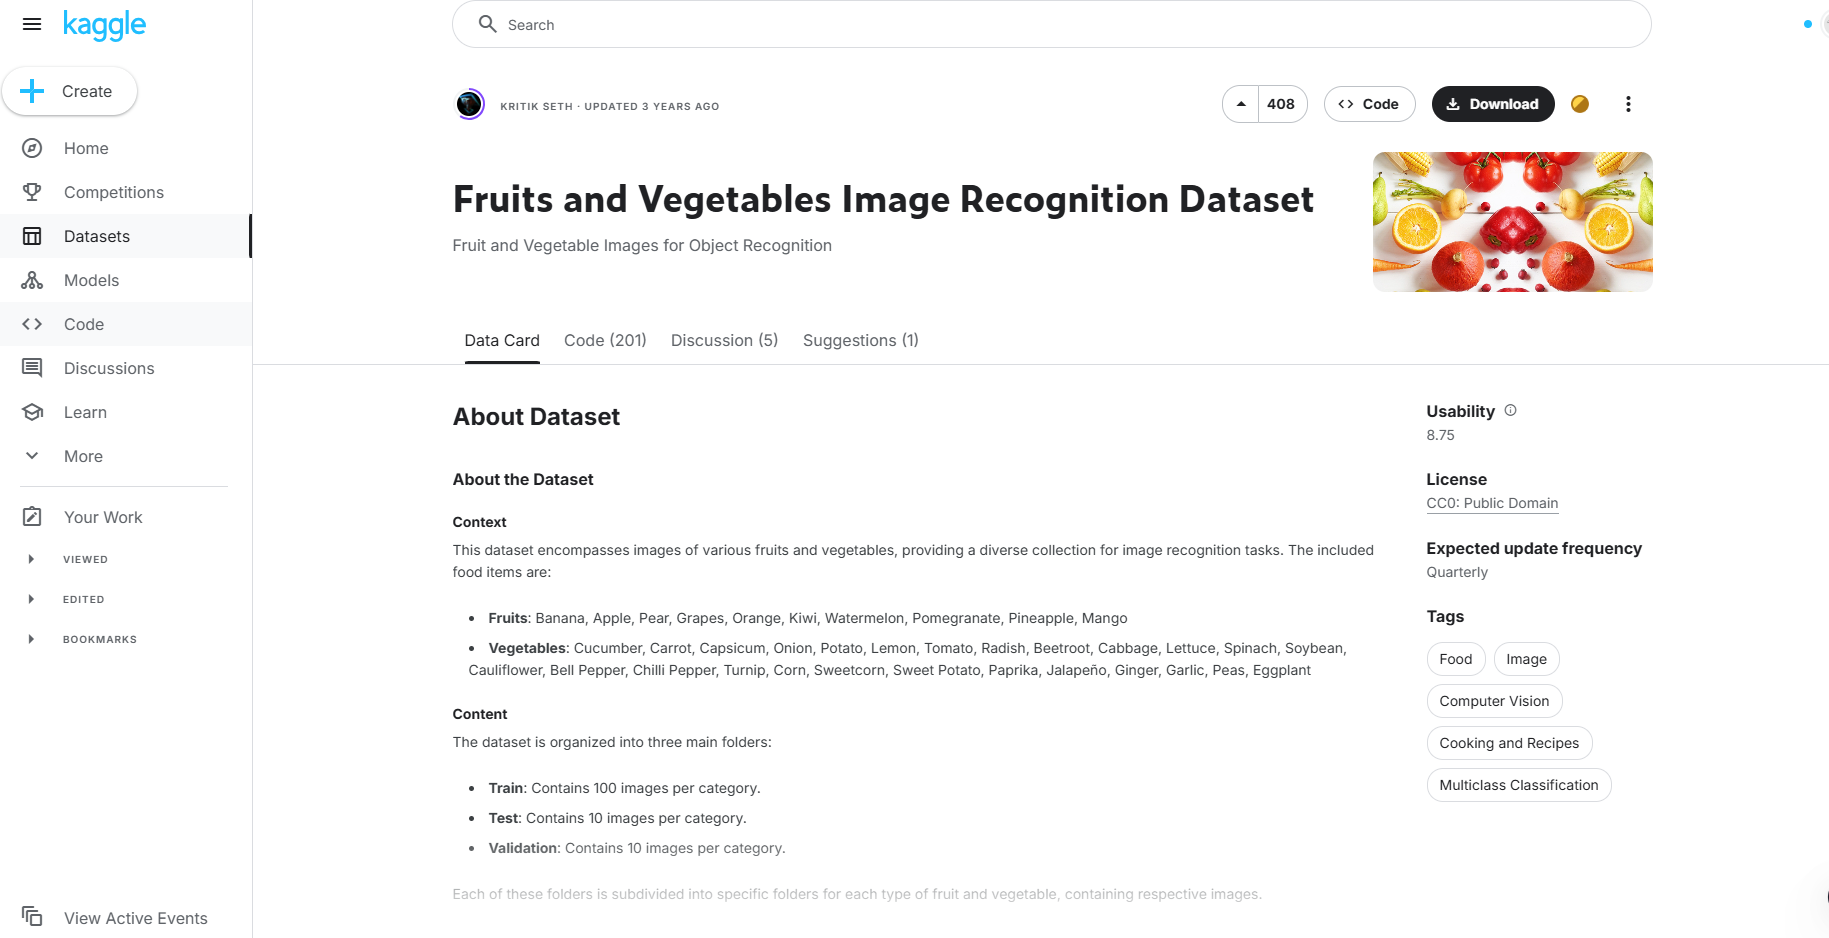

In [ ]:
# Download dataset
# !kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition
# !unzip -q fruit-and-vegetable-image-recognition.zip -d "/content/drive/MyDrive/DeepLearning/Midterm/Dataset"

##Import necessary libraries.

In [ ]:
import csv
import os
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.cuda.amp as amp

from PIL import Image
from tqdm import tqdm
from transformers import BertTokenizer, BlipProcessor, BlipForConditionalGeneration

##Configure device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_data_path = "/content/drive/MyDrive/DeepLearning/Midterm/Dataset/Fruit_vegetable/train"
output_csv_path = "/content/drive/MyDrive/DeepLearning/Midterm/Dataset/fruit_qa_dataset.csv"

#2) Data Preparation

##Load the BLIP model

In [ ]:
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

In [ ]:
def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = blip_processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        caption_ids = blip_model.generate(**inputs, max_length=50)
        caption = blip_processor.decode(caption_ids[0], skip_special_tokens=True)

    return caption if len(caption.split()) > 3 else "A photo of a fruit."

##Create a dataset in the form of question-answer (QA) pairs.

In [ ]:
# List of fruits and vegetables
fruit_list = ["apple", "banana", "grapes", "kiwi", "lemon", "mango", "orange",
              "pear", "pineapple", "pomegranate", "watermelon"]

def prepare_dataset():
    """Generates and saves the Q&A dataset to a CSV file."""
    qa_dataset = []

    for class_name in tqdm(os.listdir(train_data_path), desc="Processing classes"):
        class_path = os.path.join(train_data_path, class_name)

        if not os.path.isdir(class_path):
            continue

        for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            try:
                category = "Fruit" if class_name in fruit_list else "Vegetable"

                # Create a single row for each image
                qa_dataset.append({
                    "image": img_file,
                    "class": class_name,
                    "what_fruit": class_name,
                    "describe": "",
                    "fruit_or_vegetable": category
                })
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue

    # Save to CSV
    with open(output_csv_path, "w", newline='', encoding='utf-8') as csvfile:
        fieldnames = ['image', 'class', 'what_fruit', 'describe', 'fruit_or_vegetable']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()
        writer.writerows(qa_dataset)

    print(f"Dataset saved to {output_csv_path}")
prepare_dataset()

Processing apple: 100%|██████████| 68/68 [00:00<00:00, 162699.76it/s]

Processing banana: 100%|██████████| 75/75 [00:00<00:00, 160824.54it/s]

Processing beetroot: 100%|██████████| 88/88 [00:00<00:00, 47558.14it/s]

Processing bell pepper: 100%|██████████| 90/90 [00:00<00:00, 194280.68it/s]

Processing cabbage: 100%|██████████| 92/92 [00:00<00:00, 246251.42it/s]

Processing capsicum: 100%|██████████| 89/89 [00:00<00:00, 123077.17it/s]

Processing carrot: 100%|██████████| 82/82 [00:00<00:00, 237195.12it/s]

Processing cauliflower: 100%|██████████| 79/79 [00:00<00:00, 193319.73it/s]

Processing corn: 100%|██████████| 87/87 [00:00<00:00, 227213.23it/s]

Processing cucumber: 100%|██████████| 94/94 [00:00<00:00, 270044.23it/s]

Processing eggplant: 100%|██████████| 84/84 [00:00<00:00, 239674.51it/s]

Processing garlic: 100%|██████████| 92/92 [00:00<00:00, 253199.45it/s]

Processing ginger: 100%|██████████| 68/68 [00:00<00:00, 207427.40it/s]

Processing grapes: 100%|██████████| 100/100 [00:0

Dataset saved to /content/drive/MyDrive/DeepLearning/Midterm/Dataset/fruit_qa_dataset.csv


#3) Dataset and DataLoader Definition

##Load data from the CSV file.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Get data from CSV
def load_data_from_csv(csv_file_path):
    qa_data = []
    with open(csv_file_path, "r", encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            qa_data.append(row)
    return qa_data

qa_data = load_data_from_csv(output_csv_path)

##Implement the FruitVQADataset class.

In [ ]:
class FruitVQADataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

        # Prepare answer vocab for 'What fruit is in the image?'
        self.fruit_vocab = {label: idx for idx, label in enumerate(
            sorted(list(set(item['what_fruit'] for item in data))))}
        self.fruit_idx_to_answer = {idx: label for label, idx in self.fruit_vocab.items()}
        print("Fruit labels:", self.fruit_vocab)

        # Prepare answer vocab for 'Is this a fruit or a vegetable?'
        self.category_vocab = {'Fruit': 0, 'Vegetable': 1}
        self.category_idx_to_answer = {0: 'Fruit', 1: 'Vegetable'}
        print("Category labels:", self.category_vocab)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            item = self.data[idx]
            img_path = os.path.join(self.root_dir, item["class"], item["image"])

            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            # Tokenize questions (using just a general question for all)
            general_question = "What is in this image?"
            inputs = self.tokenizer(
                general_question,
                padding="max_length",
                truncation=True,
                max_length=20,
                return_tensors="pt"
            )

            # Prepare labels
            what_fruit_label = self.fruit_vocab[item["what_fruit"]] # Label of What_fruit
            fruit_or_vegetable_label = self.category_vocab[item["fruit_or_vegetable"]] # Label of fruit_or_vegetable

            return {
                "image": image,
                "input_ids": inputs["input_ids"].squeeze(),
                "attention_mask": inputs["attention_mask"].squeeze(),
                "what_fruit_label": torch.tensor(what_fruit_label, dtype=torch.long), # Long
                "fruit_or_vegetable_label": torch.tensor(fruit_or_vegetable_label, dtype=torch.long), # Long
            }

        except Exception as e:
            print(f"Error loading image or CSV data: {e}")
            return None

##Apply image transformations and Create DataLoader for training and validation sets.

In [ ]:
# Transform image
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn(batch):
    """Custom collate function to handle None values in the batch"""
    batch = [data for data in batch if data is not None]
    if not batch:
        return None

    images = torch.stack([item["image"] for item in batch])
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_masks = torch.stack([item["attention_mask"] for item in batch])
    what_fruit_labels = torch.stack([item["what_fruit_label"] for item in batch]) # Stack label
    fruit_or_vegetable_labels = torch.stack([item["fruit_or_vegetable_label"] for item in batch]) # Stack label

    return {
        "image": images,
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "what_fruit_label": what_fruit_labels,
        "fruit_or_vegetable_label": fruit_or_vegetable_labels
    }

# Create DataLoader
dataset = FruitVQADataset(qa_data, train_data_path, transform=image_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

Fruit labels: {'apple': 0, 'banana': 1, 'beetroot': 2, 'bell pepper': 3, 'cabbage': 4, 'capsicum': 5, 'carrot': 6, 'cauliflower': 7, 'chilli pepper': 8, 'corn': 9, 'cucumber': 10, 'eggplant': 11, 'garlic': 12, 'ginger': 13, 'grapes': 14, 'jalepeno': 15, 'kiwi': 16, 'lemon': 17, 'lettuce': 18, 'mango': 19, 'onion': 20, 'orange': 21, 'paprika': 22, 'pear': 23, 'peas': 24, 'pineapple': 25, 'pomegranate': 26, 'potato': 27, 'raddish': 28, 'soy beans': 29, 'spinach': 30, 'sweetcorn': 31, 'sweetpotato': 32, 'tomato': 33, 'turnip': 34, 'watermelon': 35}
Category labels: {'Fruit': 0, 'Vegetable': 1}


#4) Building the CNN + LSTM Model

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, vocab_size, num_fruit_classes, num_category_classes):
        super().__init__()

        # CNN (ResNet18)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 512)

        # LSTM for the question
        self.embedding = nn.Embedding(vocab_size, 256)
        self.lstm = nn.LSTM(256, 512, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.fc_fruit = nn.Linear(512 + 1024, num_fruit_classes)  # 512 (image) + 1024 (LSTM)
        self.fc_category = nn.Linear(512 + 1024, num_category_classes)

    def forward(self, image, question):
        # Image
        img_features = self.cnn(image)  # Shape: (batch_size, 512)

        # Question
        embedded = self.embedding(question)  # (batch_size, seq_len, 256)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, 1024)
        question_features = lstm_out[:, -1, :]  # (batch_size, 1024)

        # Combined
        combined = torch.cat((img_features, question_features), dim=1)

        # Classify
        fruit_output = self.fc_fruit(combined)  # Predict the fruit type
        category_output = self.fc_category(combined)  # Predict fruit or vegetable

        return fruit_output, category_output

##Model initialization

In [ ]:
model = VQAModel(
    vocab_size=tokenizer.vocab_size,
    num_fruit_classes=len(dataset.fruit_vocab),
    num_category_classes=len(dataset.category_vocab)
).to(device)

#5) Model Training

In [ ]:
def train_model(model, train_loader, val_loader, epochs, accumulation_steps=2):
    criterion_fruit = nn.CrossEntropyLoss()
    criterion_category = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    device = "cuda" if torch.cuda.is_available() else "cpu"  # Check GPU
    use_amp = torch.cuda.is_available()  # Only turn on FP16 if there is GPU

    scaler = amp.GradScaler(device_type="cuda") if use_amp else None  # Only turn on if there is GPU

    train_losses, val_losses, accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        optimizer.zero_grad()
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            if batch is None:
                continue

            images = batch["image"].to(device, non_blocking=True)
            questions = batch["input_ids"].to(device, non_blocking=True)
            what_fruit_labels = batch["what_fruit_label"].to(device, non_blocking=True)
            fruit_or_vegetable_labels = batch["fruit_or_vegetable_label"].to(device, non_blocking=True)

            if use_amp:
                with amp.autocast(device_type="cuda"):  # Use FP16 if there is GPU
                    fruit_output, category_output = model(images, questions)
                    loss_fruit = criterion_fruit(fruit_output, what_fruit_labels)
                    loss_category = criterion_category(category_output, fruit_or_vegetable_labels)
                    loss = loss_fruit + loss_category

                scaler.scale(loss).backward()  # Use Scaler if there is GPU

                if (batch_idx + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                fruit_output, category_output = model(images, questions)
                loss_fruit = criterion_fruit(fruit_output, what_fruit_labels)
                loss_category = criterion_category(category_output, fruit_or_vegetable_labels)
                loss = loss_fruit + loss_category

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item()
            _, predicted_fruit = torch.max(fruit_output.data, 1)
            _, predicted_category = torch.max(category_output.data, 1)
            total_samples += what_fruit_labels.size(0) * 2
            correct_predictions += (predicted_fruit == what_fruit_labels).sum().item()
            correct_predictions += (predicted_category == fruit_or_vegetable_labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue

                images = batch["image"].to(device, non_blocking=True)
                questions = batch["input_ids"].to(device, non_blocking=True)
                what_fruit_labels = batch["what_fruit_label"].to(device, non_blocking=True)
                fruit_or_vegetable_labels = batch["fruit_or_vegetable_label"].to(device, non_blocking=True)

                fruit_output, category_output = model(images, questions)
                loss_fruit = criterion_fruit(fruit_output, what_fruit_labels)
                loss_category = criterion_category(category_output, fruit_or_vegetable_labels)
                loss = loss_fruit + loss_category
                val_loss += loss.item()

                _, predicted_fruit = torch.max(fruit_output.data, 1)
                _, predicted_category = torch.max(category_output.data, 1)
                total_val_samples += what_fruit_labels.size(0) * 2
                correct_val_predictions += (predicted_fruit == what_fruit_labels).sum().item()
                correct_val_predictions += (predicted_category == fruit_or_vegetable_labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_val_accuracy = (correct_val_predictions / total_val_samples) * 100
        accuracies.append(avg_val_accuracy)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f} | "
              f"Val Accuracy: {avg_val_accuracy:.2f}%")
        scheduler.step()

    # Graph
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

Training Pre-trained Model...


Epoch 1/10: 100%|██████████| 78/78 [19:49<00:00, 15.25s/it]


Epoch 1 | Train Loss: 2.311 | Val Loss: 2.555 | Val Accuracy: 62.92%


Epoch 2/10: 100%|██████████| 78/78 [12:46<00:00,  9.83s/it]


Epoch 2 | Train Loss: 1.604 | Val Loss: 2.585 | Val Accuracy: 69.90%


Epoch 3/10: 100%|██████████| 78/78 [12:57<00:00,  9.97s/it]


Epoch 3 | Train Loss: 1.235 | Val Loss: 2.593 | Val Accuracy: 71.35%


Epoch 4/10: 100%|██████████| 78/78 [12:46<00:00,  9.82s/it]


Epoch 4 | Train Loss: 1.136 | Val Loss: 1.822 | Val Accuracy: 76.16%


Epoch 5/10: 100%|██████████| 78/78 [12:44<00:00,  9.80s/it]


Epoch 5 | Train Loss: 0.870 | Val Loss: 3.434 | Val Accuracy: 69.90%


Epoch 6/10: 100%|██████████| 78/78 [12:41<00:00,  9.76s/it]


Epoch 6 | Train Loss: 0.461 | Val Loss: 0.952 | Val Accuracy: 84.67%


Epoch 7/10: 100%|██████████| 78/78 [12:41<00:00,  9.76s/it]


Epoch 7 | Train Loss: 0.290 | Val Loss: 0.943 | Val Accuracy: 86.44%


Epoch 8/10: 100%|██████████| 78/78 [12:47<00:00,  9.84s/it]


Epoch 8 | Train Loss: 0.244 | Val Loss: 0.954 | Val Accuracy: 86.60%


Epoch 9/10: 100%|██████████| 78/78 [12:41<00:00,  9.76s/it]


Epoch 9 | Train Loss: 0.203 | Val Loss: 0.944 | Val Accuracy: 86.44%


Epoch 10/10: 100%|██████████| 78/78 [12:41<00:00,  9.77s/it]


Epoch 10 | Train Loss: 0.167 | Val Loss: 0.960 | Val Accuracy: 86.60%


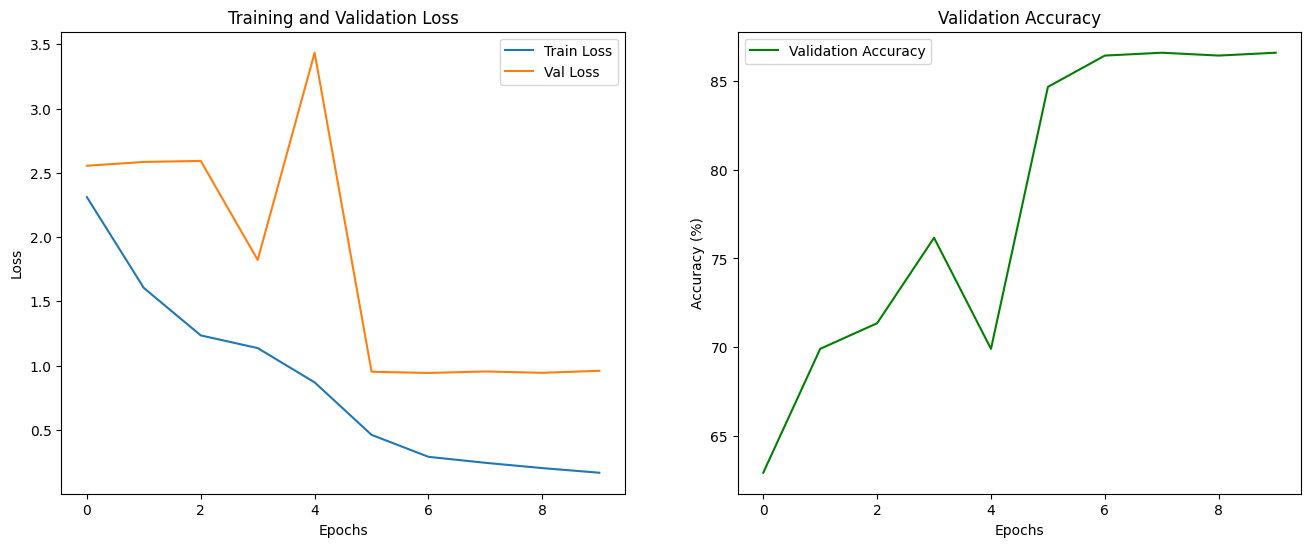

In [ ]:
# Model training
print("Training Pre-trained Model...")
train_model(model, train_loader, val_loader, epochs=10)

#6) Save Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DeepLearning/Midterm/Model/vqamodel.pth')
print("Model saved successfully!")

Model saved successfully!


#7) Prediction

##Define the predict() function.

In [ ]:
def predict(image_path):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device) # Image tensor

    # Generate caption (description) using BLIP
    inputs = blip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        caption_ids = blip_model.generate(**inputs, max_length=50)
        caption = blip_processor.decode(caption_ids[0], skip_special_tokens=True)

    with torch.no_grad():
        fruit_output, category_output = model(image_tensor, torch.zeros((1, 20), dtype=torch.long).to(device))  # Use image_tensor
        predicted_fruit_idx = torch.argmax(fruit_output).item()
        predicted_category_idx = torch.argmax(category_output).item()
        predicted_fruit = dataset.fruit_idx_to_answer[predicted_fruit_idx]
        predicted_category = dataset.category_idx_to_answer[predicted_category_idx]

    return predicted_fruit, predicted_category, caption

##Predict on some new images

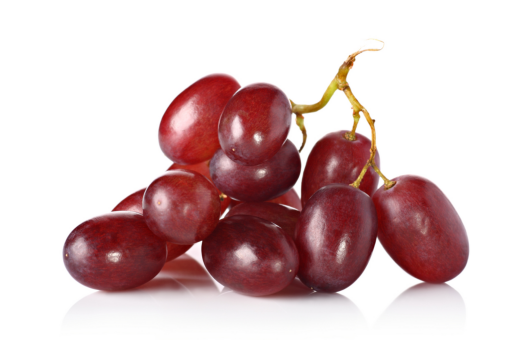

What fruit is in the image?: grapes
Is this a fruit or a vegetable?: Fruit
Describe the image: a bunch of grapes
--------------------------------------------------


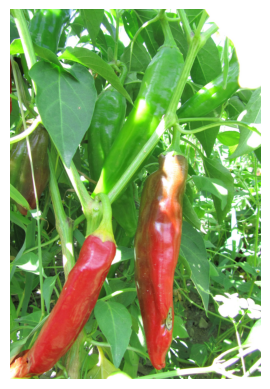

What fruit is in the image?: paprika
Is this a fruit or a vegetable?: Vegetable
Describe the image: a bunch of peppers growing in a garden
--------------------------------------------------


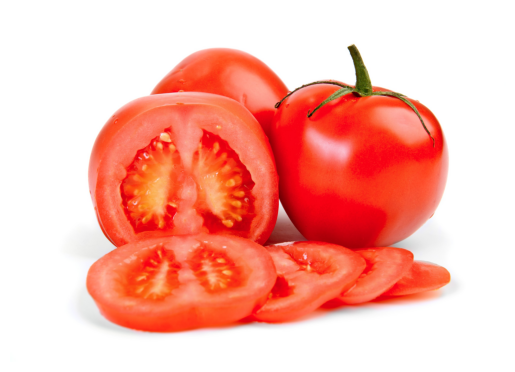

What fruit is in the image?: tomato
Is this a fruit or a vegetable?: Vegetable
Describe the image: a tomato and a half of tomato
--------------------------------------------------


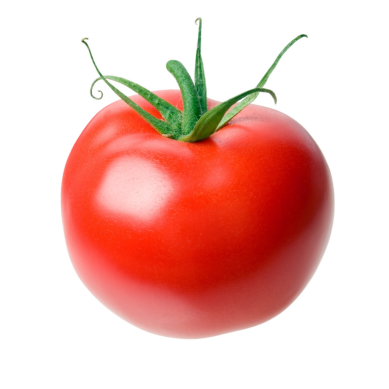

What fruit is in the image?: tomato
Is this a fruit or a vegetable?: Vegetable
Describe the image: a red tomato with a green stem on a white background
--------------------------------------------------


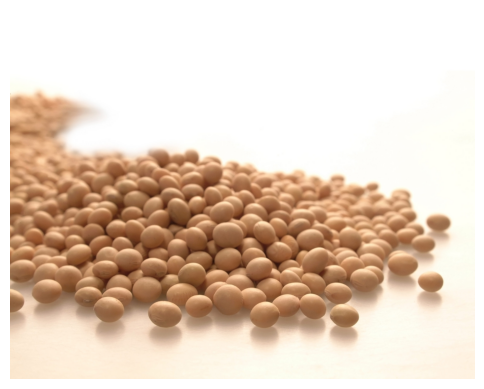

What fruit is in the image?: soy beans
Is this a fruit or a vegetable?: Vegetable
Describe the image: a pile of soy beans
--------------------------------------------------


In [ ]:
# Demo

# Path to your test images directory
test_image_dir = "/content/drive/MyDrive/DeepLearning/Midterm/Dataset/Fruit_vegetable/test"

# Get a list of all image files in the test directory
all_image_files = []
for root, _, files in os.walk(test_image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_image_files.append(os.path.join(root, file))

# Select 5 random image files
test_images = random.sample(all_image_files, 5)

# Process and display each selected image
for image_path in test_images:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    predicted_fruit, predicted_category, caption = predict(image_path)

    print(f"What fruit is in the image?: {predicted_fruit}")
    print(f"Is this a fruit or a vegetable?: {predicted_category}")
    print(f"Describe the image: {caption}")
    print("-" * 50)